<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/TimeSeriesTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installers

In [11]:
!pip install transformers torch
!pip install pandas scikit-learn

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt


# Read dataset from google drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load the dataset
# /content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)


In [15]:
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())
print('----------------------RUL Data----------------------')
print(rul_data.head())

sensor_cols = train_data.columns[2:]  # Exclude 'id' and 'cycle'

scaler = StandardScaler()
train_data.iloc[:, 5:] = scaler.fit_transform(train_data.iloc[:, 5:])
test_data.iloc[:, 5:] = scaler.transform(test_data.iloc[:, 5:])


---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   sensor17  sensor18  sensor19  sensor

# Calcular RUL data test

In [16]:
# Generate RUL for training data
max_cycle = train_data.groupby('id')['cycle'].max()
train_data = train_data.merge(max_cycle.reset_index(), on='id', suffixes=('', '_max'))
train_data['RUL'] = train_data['cycle_max'] - train_data['cycle']
train_data.drop(columns=['cycle_max'], inplace=True)

# Calculate RUL for the test data
max_cycle_test = test_data.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id', 'max_cycle']
rul_data.columns = ['RUL']
max_cycle_test['RUL'] = rul_data['RUL']
test_data = test_data.merge(max_cycle_test, on='id')
test_data['RUL'] = test_data['RUL'] + test_data['max_cycle'] - test_data['cycle']
test_data.drop(columns=['max_cycle'], inplace=True)

# Now test_data['RUL'] has the correct RUL values, and you won't pass it to the scaler

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())


---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1   sensor2   sensor3  \
0   1      1   -0.0007   -0.0004     100.0      0.0 -1.721725 -0.134255   
1   1      2    0.0019   -0.0003     100.0      0.0 -1.061780  0.211528   
2   1      3   -0.0043    0.0003     100.0      0.0 -0.661813 -0.413166   
3   1      4    0.0007    0.0000     100.0      0.0 -0.661813 -1.261314   
4   1      5   -0.0019   -0.0002     100.0      0.0 -0.621816 -1.251528   

    sensor4       sensor5  ...  sensor13  sensor14  sensor15      sensor16  \
0 -0.925936 -1.776357e-15  ... -1.058890 -0.269071 -0.603816 -1.387779e-17   
1 -0.643726 -1.776357e-15  ... -0.363646 -0.642845 -0.275852 -1.387779e-17   
2 -0.525953 -1.776357e-15  ... -0.919841 -0.551629 -0.649144 -1.387779e-17   
3 -0.784831 -1.776357e-15  ... -0.224597 -0.520176 -1.971665 -1.387779e-17   
4 -0.301518 -1.776357e-15  ... -0.780793 -0.521748 -0.339845 -1.387779e-17   

   sensor17  sensor18  sens

# Pre processing

In [17]:
# Prepare sequences for the transformer model
def create_sequences(data, seq_length=50):
    sequences = []
    for unit in data['id'].unique():
        unit_data = data[data['id'] == unit].reset_index(drop=True)
        for start in range(len(unit_data) - seq_length + 1):
            end = start + seq_length
            seq_X = unit_data.iloc[start:end, 2:-1].values  # Select settings and sensor columns
            seq_y = unit_data.iloc[end-1]['RUL']
            sequences.append((seq_X, seq_y))
    return sequences

seq_length = 50
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

In [18]:
# Split training data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(
    [seq[0] for seq in train_sequences],
    [seq[1] for seq in train_sequences],
    test_size=0.2,
    random_state=42
)

# Convert to numpy arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)
test_X = np.array([seq[0] for seq in test_sequences])
test_y = np.array([seq[1] for seq in test_sequences])

# Convert to PyTorch tensors
import torch
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# Define model

In [19]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
        self.input_projection = nn.Linear(input_dim, model_dim)

    def forward(self, src):
        src = self.input_projection(src)
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)
        output = self.transformer_encoder(src)
        output = output.mean(dim=0)  # Pooling
        output = self.fc(output)
        return output

# Define model
input_dim = train_X.shape[2]
model_dim = 64
num_heads = 8
num_layers = 4
output_dim = 1

model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers, output_dim)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#Train Model


In [20]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20
batch_size = 32

# Create DataLoader
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/20, Train Loss: 6961.0463, Val Loss: 4003.1171
Epoch 2/20, Train Loss: 3495.1080, Val Loss: 3261.7386
Epoch 3/20, Train Loss: 3257.0310, Val Loss: 3275.3136
Epoch 4/20, Train Loss: 3294.7233, Val Loss: 3283.9925
Epoch 5/20, Train Loss: 3290.9521, Val Loss: 3274.3409
Epoch 6/20, Train Loss: 3296.0790, Val Loss: 3286.6404
Epoch 7/20, Train Loss: 3310.7769, Val Loss: 3283.5477
Epoch 8/20, Train Loss: 3300.3669, Val Loss: 3285.4580
Epoch 9/20, Train Loss: 3301.6189, Val Loss: 3290.1745
Epoch 10/20, Train Loss: 3300.3685, Val Loss: 3292.4012
Epoch 11/20, Train Loss: 3222.9487, Val Loss: 3300.5768
Epoch 12/20, Train Loss: 3300.5116, Val Loss: 3271.3684
Epoch 13/20, Train Loss: 3299.1063, Val Loss: 3269.0447
Epoch 14/20, Train Loss: 3301.5798, Val Loss: 3282.7662
Epoch 15/20, Train Loss: 3298.5166, Val Loss: 3291.8551
Epoch 16/20, Train Loss: 3298.6936, Val Loss: 3282.8039
Epoch 17/20, Train Loss: 3298.8549, Val Loss: 3292.1077
Epoch 18/20, Train Loss: 3296.9961, Val Loss: 3288.7447
E

# Evalute Model


In [21]:
# Convert test data into DataLoader
test_dataset = TensorDataset(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_predictions = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        test_loss += loss.item()
        test_predictions.append(outputs.squeeze().cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Flatten test_predictions to match test_y
test_predictions = np.concatenate(test_predictions)


Test Loss: 3365.5456


In [22]:
torch.save(model.state_dict(), 'turbofan_transformer_model.pth')


# Results


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert test_y to numpy
test_y_np = test_y.cpu().numpy()

# Calculate RMSE and MAE
rmse = mean_squared_error(test_y_np, test_predictions, squared=False)
mae = mean_absolute_error(test_y_np, test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


RMSE: 58.0134
MAE: 45.9310


## Loss Curves and Scatter plot

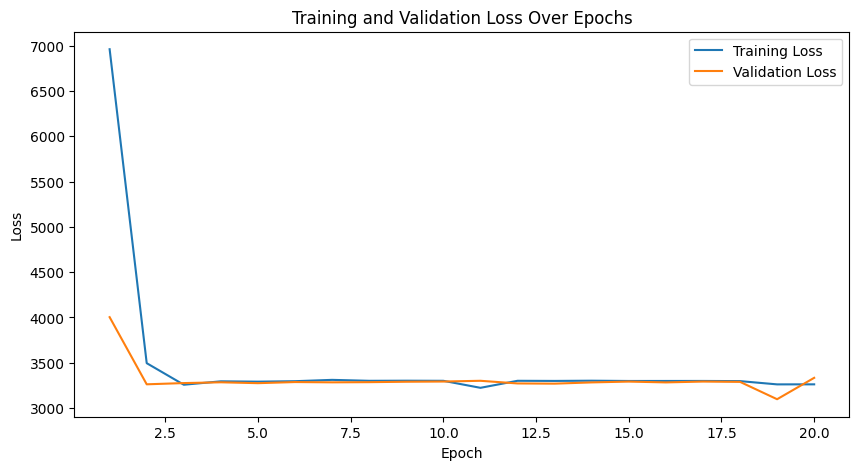

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()


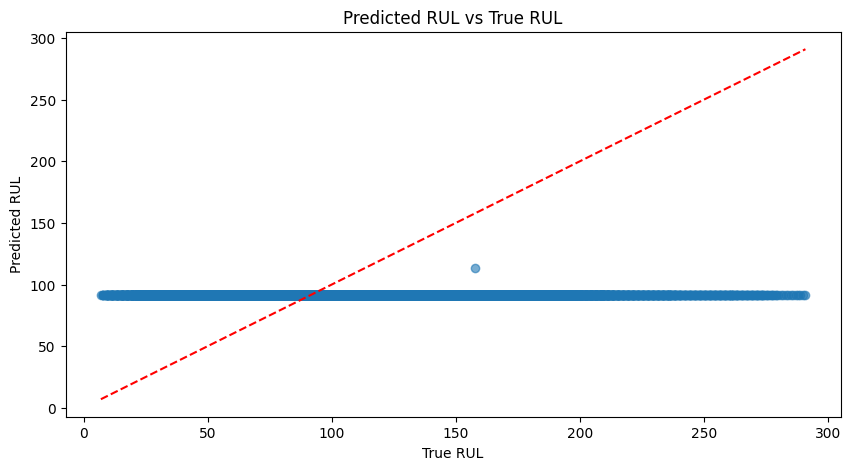

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(test_y_np, test_predictions, alpha=0.6)
plt.plot([test_y_np.min(), test_y_np.max()], [test_y_np.min(), test_y_np.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted RUL vs True RUL')
plt.show()


In [29]:
print(f"Performance Summary:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nTest Loss (MSE): {test_loss:.4f}")


Performance Summary:
RMSE: 58.0134
MAE: 45.9310
Test Loss (MSE): 3365.5456
